# Latent Dirichlet Allocation

LDA is probably the most commonly evoked algorithm when talking about unsupervised topic modeling. Here, we look at what topics we can generate and use the coherence evaluation metric to give us an idea of how many topics to generate, as well as the alpha and eta parameters.

In [1]:
import pandas as pd
import numpy as np
import re 
import random
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import LdaMulticore

In [2]:
from helpers.preprocessing import *

[nltk_data] Downloading package stopwords to /home/noe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
df = load('data/impresso3.csv')

In [6]:
df.head()

,uid,type,language,title,size,country,newspaper,issue,pages,nb_pages,...,year,is_on_front,date,persons_mentioned,locations_mentioned,content,access_right,content_provider,is_content_available,"[total:7120,available:7200]"
0,JDG-1964-04-29-a-i0007,NaN,fr,"Un jour en Suisse"" sera insuffisant pour décou...",1185,CH,JDG,JDG-1964-04-29-a,2,1,...,1964,False,1964-04-29 00:00:00+00:00,"Les Sécuritas|M. Gabriel Despland, président|M...",Suisse|Lausanne|Suisse|Lausanne|Suisse|Lausanne,"Un jour en Suisse "" sera insuffisant pour déco...",OpenPrivate,SNL,y,NaN
1,GDL-1964-10-16-a-i0035,NaN,fr,Après une campagne de protestation 500 000 vis...,601,CH,GDL,GDL-1964-10-16-a,3,1,...,1964,False,1964-10-16 00:00:00+00:00,"M. Charles Apothéloz, directeur|M. Hans Giger|...",Suisse|Suisse|Lausanne|Lausanne|Bern|Suisse,Après une campagne de protestation 500 000 vis...,OpenPrivate,SNL,y,NaN
2,luxland-1968-04-26-a-i0033,NaN,fr,L'ordinateur n'est un épouvantail que pour les...,430,LU,luxland,luxland-1968-04-26-a,6,1,...,1968,False,1968-04-26 00:00:00+00:00,"Irving Adler, spécialiste américain",NaN,NaN,Closed,BNL,NaN,NaN
3,EXP-1970-04-20-a-i0053,NaN,fr,"Â Bâle, la formation professionnelle horlogère",342,CH,EXP,EXP-1970-04-20-a,3,1,...,1970,False,1970-04-20 00:00:00+00:00,NaN,Bâle|Bâle,"Â Bâle, la formation professionnelle horlogère...",OpenPrivate,SNL,y,NaN
4,IMP-1970-04-21-a-i0174,NaN,fr,NaN,324,CH,IMP,IMP-1970-04-21-a,14,1,...,1970,False,1970-04-21 00:00:00+00:00,NaN,Bâle,Stand «Formation professionnelle horlogère » à...,OpenPrivate,SNL,y,NaN


In [7]:
# The column that we are interested in
df.content.head()

0    Un jour en Suisse " sera insuffisant pour déco...
1    Après une campagne de protestation 500 000 vis...
2                                                  NaN
3    Â Bâle, la formation professionnelle horlogère...
4    Stand «Formation professionnelle horlogère » à...
Name: content, dtype: object

In [8]:
df.shape

(7120, 21)

In [9]:
# As our dataset was manually extracted using keywords, we did our best to manually remove irrelevant articles,
# especially large ones
# The cleanup function removes these as well as nan values and very short articles that are mostly advertisements
df = cleanup(df)

/media/Common/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
# As we can see, we are left with a much smaller dataset
df.shape

(4352, 21)

### Preprocessing

In [11]:
# spacy_prep removes stopwords, punctuation, numbers, and adds bigrams and entities
data = spacy_prep(df.content)

In [12]:
# Remove words that appear in more than 30% of the articles and words that appear less than 3 times
min_words = 3
max_freq = 0.3

In [13]:
# create_corpus creates a spacy dictionary and corpus 
dictionary, corpus = create_corpus(data, min_words, max_freq)

### LDA

In [14]:
from helpers.models import *

First, we can choose an arbitrary number of topics (5) and look at what kinds of topics are generated.

In [15]:
workers = 6
passes = 10
random_state = 123
num_topics = 5
lda_model = lda(dictionary, corpus, num_topics, workers, passes, random_state, None, None)

In [16]:
lda_model.show_topics(formatted=False, num_topics=5, num_words = 10)

[(0,
  [('film', 0.0069710407),
   ('enfant', 0.00598608),
   ('jeune', 0.004223193),
   ('voir', 0.0028155367),
   ('histoire', 0.0024370425),
   ('prendre', 0.0024238096),
   ('vie', 0.0023739657),
   ('annee', 0.0022975206),
   ('image', 0.002252371),
   ('fois', 0.0022471268)]),
 (1,
  [('jeune', 0.004820364),
   ('marche', 0.0038021025),
   ('enfant', 0.0037621406),
   ('annee', 0.0035461304),
   ('million', 0.0034903085),
   ('suisse', 0.0033885813),
   ('ete', 0.0030146057),
   ('franc', 0.0029001075),
   ('pouvoir', 0.0025041115),
   ('societe', 0.0023417978)]),
 (2,
  [('pouvoir', 0.002882625),
   ('offrir', 0.0027393934),
   ('pokemon', 0.0026189792),
   ('neuchatel', 0.0023844587),
   ('ete', 0.002204082),
   ('semaine', 0.0020882366),
   ('prendre', 0.0019473681),
   ('carte', 0.0019343833),
   ('jouer', 0.0019324634),
   ('ville', 0.0019107787)]),
 (3,
  [('console', 0.008508541),
   ('nintendo', 0.007158203),
   ('playstation', 0.0053077997),
   ('titre', 0.004126778),
  

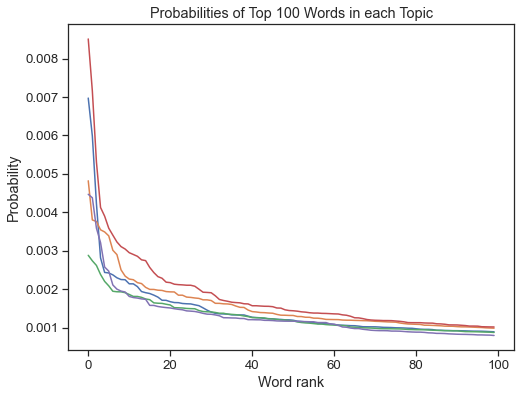

In [17]:
# Here we can see that the importance of words in each topic decreases pretty significantly
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# top 100 words by weight in each topic
top_words = 100
topics = lda_model.show_topics(
    num_topics = 20, num_words = top_words, formatted = False)

for _, infos in topics:
    probs = [prob for _, prob in infos]
    plt.plot(range(top_words), probs)

plt.xlabel('Word rank')
plt.ylabel('Probability')
plt.title('Probabilities of Top 100 Words in each Topic')
plt.show()

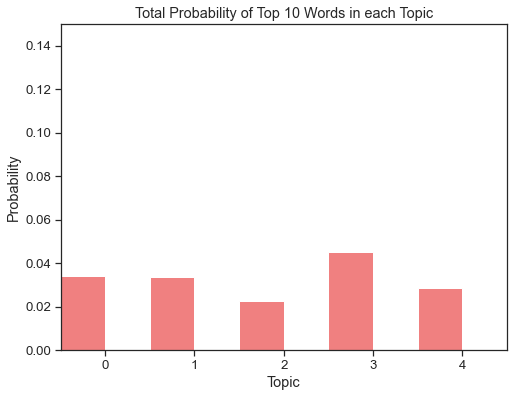

In [18]:
# total weight assigned by each topic to its top 10 words
top_probs = []
top_n_words = 10
topics = lda_model.show_topics(num_words = top_n_words, formatted = False, num_topics=5)
for _, infos in topics:
    prob = sum([prob for _, prob in infos])
    top_probs.append(prob)

ind = np.arange(5)
width = 0.5

fig, ax = plt.subplots()

ax.bar(ind - (width / 2), top_probs, width, color = 'lightcoral')
ax.set_xticks(ind)

plt.xlabel('Topic')
plt.ylabel('Probability')
plt.title('Total Probability of Top 10 Words in each Topic')
plt.xlim(-0.5, 4.5)
plt.ylim(0, 0.15)
plt.show()

We can see that top 10 words for a topic don't even account for 5% of the topic's total probability mass.

### Hyperparameter Tuning

Now let's look at which number of topics gives the best coherence.

alpha is a parameter that controls the prior distribution over topic weights in each document, while eta is a parameter for the prior distribution over word weights in each topic.

A higher alpha makes the document preferences "smoother" over topics, and a higher eta makes the topic preferences "smoother" over words.


In [ ]:
# Look at coherences with the default alpha and eta
workers = 6
passes = 5
random_state =123
n_topics = np.arange(6, 18)
coherences_1 = []
coherences_2 = []
models = []
for n in n_topics:
    lda_model = lda(dictionary, corpus, n, workers, passes, random_state, None, None)
    models.append(lda_model)
    coherences_1.append(compute_coherence(lda_model, data, corpus, dictionary, 'c_v'))
    coherences_2.append(compute_coherence(lda_model, data, corpus, dictionary, 'u_mass'))


In [149]:
n_topics = np.arange(6, 18)
coherence_df1 = pd.DataFrame([n_topics, coherences_1, coherences_2]).transpose()
coherence_df1.columns = ['num_topics', 'c_v', 'u_mass']
coherence_df1 = coherence_df1.sort_values(by = 'c_v', ascending=False)
coherence_df1.head(7)

,num_topics,c_v,u_mass
1,7.0,0.397807,-1.461332
2,8.0,0.374710,-1.487827
0,6.0,0.366287,-1.474992
3,9.0,0.363595,-1.546207
5,11.0,0.353844,-1.584117
7,13.0,0.352181,-1.635198
8,14.0,0.351721,-1.640127


In [137]:
# Here are the results without running above cells
coherence_df1 = pd.read_csv("coherence/default_ae_coherence.csv")

In [ ]:
# Don't run --- takes a long time
# Try topic sizes from 6 to 16 and compute coherences (for the entire corpus)
# Try alpha and eta values

workers = 6
passes = 5
random_state =123
n_topics = np.arange(6, 17)
alphas = [20, 0.01, 0.05]
etas = [20, 0.01, 0.05]
coherences_1 = []
coherences_2 = []
models = []
passed = []
alphas_col = []
etas_col = []
for n in n_topics:
    for a in alphas:
        for e in etas:
            # some values give an underflow error
            try:
                lda_model = lda(dictionary, corpus, n, workers, passes, random_state, a, e)
                models.append(lda_model)
                coherences_1.append(compute_coherence(lda_model, data, corpus, dictionary, 'c_v'))
                coherences_2.append(compute_coherence(lda_model, data, corpus, dictionary, 'u_mass'))
                alphas_col.append(a)
                etas_col.append(e)
            except:
                passed.append((n, a, e))

In [142]:
# Don't run -- can read in results in cell below
# Create a dataframe looking at the coherence values for the different number of topics and alphas and etas
n_topics = np.repeat(np.arange(6, 17), 5)
coherence_df = pd.DataFrame([n_topics, alphas_col, etas_col, coherences_1, coherences_2]).transpose()
coherence_df.columns = ['num_topics', 'alpha', 'eta', 'c_v', 'u_mass']
coherence_df = coherence_df.sort_values(by = 'c_v', ascending=False)
coherence_df.head(7)

,num_topics,alpha,eta,c_v,u_mass
9,7.0,0.05,0.05,0.390164,-1.456707
14,8.0,0.05,0.05,0.368559,-1.486627
4,6.0,0.05,0.05,0.368368,-1.474733
19,9.0,0.05,0.05,0.365530,-1.527821
29,11.0,0.05,0.05,0.355659,-1.584626
44,14.0,0.05,0.05,0.353315,-1.652299
39,13.0,0.05,0.05,0.351852,-1.635522


In [ ]:
# Results without running above cells
coherence_df = pd.read_csv("coherence/tuning2.csv")

We can see that the best c_v and u_mass coherence is achieved for 7 topics with alpha 0.05 and eta 0.05. 

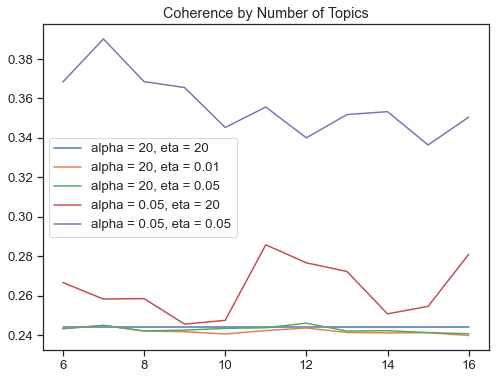

In [161]:
# Plot the coherence for the different combinations
coherencedf_20_20 = coherence_df[(coherence_df.alpha == 20) & (coherence_df.eta == 20)].sort_values(by = 'num_topics')
coherencedf_20_01 = coherence_df[(coherence_df.alpha == 20) & (coherence_df.eta == 0.01)].sort_values(by = 'num_topics')
coherencedf_20_05 = coherence_df[(coherence_df.alpha == 20) & (coherence_df.eta == 0.05)].sort_values(by = 'num_topics')
coherencedf_05_20 = coherence_df[(coherence_df.alpha == 0.05) & (coherence_df.eta == 20)].sort_values(by = 'num_topics')
coherencedf_05_05 = coherence_df[(coherence_df.alpha == 0.05) & (coherence_df.eta == 0.05)].sort_values(by = 'num_topics')

plt.plot(coherencedf_20_20.num_topics, coherencedf_20_20.c_v, label = "alpha = 20, eta = 20")
plt.plot(coherencedf_20_01.num_topics, coherencedf_20_01.c_v, label = "alpha = 20, eta = 0.01")
plt.plot(coherencedf_20_05.num_topics, coherencedf_20_05.c_v, label = "alpha = 20, eta = 0.05")
plt.plot(coherencedf_05_20.num_topics, coherencedf_05_20.c_v, label = "alpha = 0.05, eta = 20")
plt.plot(coherencedf_05_05.num_topics, coherencedf_05_05.c_v, label = "alpha = 0.05, eta = 0.05")
plt.title("Coherence by Number of Topics")
plt.legend()

Another way that we can evaluate the models is by creating a training and testing set and then computing the perplexity on the test set.

### Train and Test

In [24]:
# Choose 80% of the articles for training and 20% for testing
train, test = train_test_split(data, 0.8)

/Users/meghanharrington/ml-project-2-turboml/helpers/preprocessing.py:209: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  content=np.array(data)


In [25]:
# Create a dictionary and a corpus for the train data and create a test corpus based on the training dictionary
dictionary_train, corpus_train = create_corpus(train, min_words, max_freq)
corpus_test = create_test_corpus(dictionary_train, test)

In [ ]:
# Here we will just look at perplexity
workers = 6
passes = 5
random_state =123
num_words = 10
# based on previous results we can look at a tighter range of topics
n_topics = np.arange(8, 16)
coherences_1 = []
coherences_2 = []
perplexities = []
for n in n_topics:
    lda_model = lda(dictionary_train, corpus_train, n, workers, passes, random_state, _, _)
    perplexities.append(compute_perplexity(lda_model, corpus_test))

In [30]:
perplexity_df = pd.DataFrame([n_topics, perplexities]).transpose()
perplexity_df.columns = ['num_topics', 'perplexity']
perplexity_df.sort_values(by = 'perplexity')

,num_topics,perplexity
7,15.0,-10.557676
6,14.0,-10.539429
5,13.0,-10.518393
4,12.0,-10.494238
3,11.0,-10.466161
2,10.0,-10.433085
1,9.0,-10.394000
0,8.0,-10.347472


This doesn't appear to be a very helpful metric, the perplexities are monotone decreasing as topics increase.

# Generate topics

Although the model with 7 topics had the highest coherence, with topic modeling the best evaluation is looking at the topics manually. It seems like with 9 topics, we get a bit more variety. So we can load the trained lda model with 9 topics and alpha and eta parameters of 0.05.

**Important note:** the following analysis rely on the topics generated by our model at the time.
The documentation of `lda_model.show_topics` seems to say that the returned topics might change on different run of the model; thus the following analysis might be off if you try to retrain the model again.

In [14]:
# Load pretrained LDA Model to be used
lda_model = LdaMulticore.load("models/model_9_05_05.lda")

# To train the model
# lda_model = lda(dictionary, corpus, 9, workers, passes, random_state, 0.05, 0.05)

In [38]:
lda_model.show_topics(formatted=False, num_words = 15, num_topics=9)

[(0,
  [('console', 0.009812394),
   ('nintendo', 0.007766979),
   ('playstation', 0.0046109883),
   ('sony', 0.004050902),
   ('machine', 0.003290493),
   ('ecran', 0.0031547493),
   ('super', 0.0029830923),
   ('cartouche', 0.0027458032),
   ('sega', 0.0026806663),
   ('suisse', 0.002668474),
   ('offrir', 0.0026008056),
   ('mario', 0.0025557762),
   ('prix', 0.0024679613),
   ('annee', 0.0023843648),
   ('enfant', 0.0023799601)]),
 (1,
  [('pouvoir', 0.003800191),
   ('film', 0.0037765354),
   ('console', 0.0036592416),
   ('combat', 0.0034860547),
   ('propose', 0.0026860684),
   ('ecran', 0.002633324),
   ('coup', 0.002473909),
   ('playstation', 0.0024595342),
   ('action', 0.0024416964),
   ('jour', 0.002367328),
   ('nintendo', 0.0023626431),
   ('mission', 0.002354833),
   ('mario', 0.0023145827),
   ('personnage', 0.0023083698),
   ('ete', 0.0021666628)]),
 (2,
  [('film', 0.006178176),
   ('jeune', 0.0034489261),
   ('suisse', 0.0030741226),
   ('course', 0.0028587028),
   

In [108]:
# Create a dataframe with the top 15 words for each topic and a brief description for each one
words = []
for topic in lda_model.show_topics(formatted=False, num_words = 15, num_topics=15):
    temp = []
    for (word, prob) in topic[1]:
        temp.append(word)
    words.append(temp)
words
    
# Those briefs are either a subset of the words assigned to the topic, or come from the analysis
# which is beign performed at the end of this notebook, which we used to then rename those categories
brief = ['consoles playstation nintendo', '"VideoGames&Cinema1"', '"VideoGames&Cinema2"', 
         'children school young time', '"Education"', '"Violence"', '"Politics"',  
         '"Economics"', '"Game news"']

topic_df = pd.DataFrame(list(zip(words,brief)), columns=['words','brief'])
topic_df

,words,brief
0,"[console, nintendo, playstation, sony, machine...",consoles playstation nintendo
1,"[pouvoir, film, console, combat, propose, ecra...","""VideoGames&Cinema1"""
2,"[film, jeune, suisse, course, mode, histoire, ...","""VideoGames&Cinema2"""
3,"[enfant, film, suisse, heure, jour, jeune, pou...",children school young time
4,"[enfant, jeune, personnage, voir, prendre, dev...","""Education"""
5,"[jeune, enfant, violence, film, parent, voir, ...","""Violence"""
6,"[jeune, million, ete, franc, enfant, suisse, c...","""Politics"""
7,"[million, annee, marche, ete, suisse, franc, i...","""Economics"""
8,"[console, nintendo, titre, mode, playstation, ...","""Game news"""


In [107]:
# For each document get which topic it probably belongs to
article_topics = []
for i, doc in enumerate(data):
    bow = dictionary.doc2bow(doc)
    doc_topics, word_topics, phi_values = lda_model.get_document_topics(
        bow, per_word_topics = True)
    article_topics.append(doc_topics)

In [109]:
classified = pd.DataFrame({'article': df.content, 'topics': article_topics})
classified.head()

,article,topics
0,"Un jour en Suisse "" sera insuffisant pour déco...","[(1, 0.11784285), (2, 0.025124976), (3, 0.1007..."
1,Après une campagne de protestation 500 000 vis...,"[(5, 0.24079965), (6, 0.37143046), (7, 0.35921..."
2,"Â Bâle, la formation professionnelle horlogère...","[(3, 0.82927465), (4, 0.013119309), (6, 0.0675..."
3,Stand «Formation professionnelle horlogère » à...,"[(3, 0.8345946), (4, 0.022407984), (6, 0.04952..."
4,Luciano Berio à Genève Peter Maag à Zurich et ...,"[(1, 0.06794338), (2, 0.26038378), (3, 0.30930..."


In [110]:
# Get the assigned topics for each article
assigned_topics = []
for probs in classified.topics:
    temp = []
    for (t, p) in probs:
        temp.append(t)
    assigned_topics.append(temp)
classified['assigned_topics'] = assigned_topics
classified['year'] = df.year

In [111]:
# create one hot vectors for each article and topic (1 if the topic is in the article's distribution, 0 if not)
one_hots = []

for probs in classified.topics:
    onehot = np.zeros(9)
    for (t, p) in probs:
        onehot[t] = 1
    one_hots.append(onehot)
one_hots
one_hot_matrix = np.stack(one_hots, axis=1)
for i in range(9):
    classified["topic{}".format(i)] = one_hot_matrix[i]
classified.head()

,article,topics,assigned_topics,year,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8
0,"Un jour en Suisse "" sera insuffisant pour déco...","[(1, 0.11784285), (2, 0.025124976), (3, 0.1007...","[1, 2, 3, 4, 5, 6, 7, 8]",1964,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,Après une campagne de protestation 500 000 vis...,"[(5, 0.24079965), (6, 0.37143046), (7, 0.35921...","[5, 6, 7, 8]",1964,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,"Â Bâle, la formation professionnelle horlogère...","[(3, 0.82927465), (4, 0.013119309), (6, 0.0675...","[3, 4, 6, 7]",1970,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
3,Stand «Formation professionnelle horlogère » à...,"[(3, 0.8345946), (4, 0.022407984), (6, 0.04952...","[3, 4, 6, 7]",1970,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
4,Luciano Berio à Genève Peter Maag à Zurich et ...,"[(1, 0.06794338), (2, 0.26038378), (3, 0.30930...","[1, 2, 3, 4, 5, 6]",1970,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [112]:
# Instead of assigning each topic for a document 1.0, assign it the probability that LDA outputs
classified2 = classified.drop(['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8'], axis=1)
classified2

one_hots = []
for probs in classified2.topics:
    onehot = np.zeros(9)
    for (t, p) in probs:
        onehot[t] = p
    one_hots.append(onehot)
one_hots
one_hot_matrix = np.stack(one_hots, axis=1)
for i in range(9):
    classified2["topic{}".format(i)] = one_hot_matrix[i]
classified2.head()

,article,topics,assigned_topics,year,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8
0,"Un jour en Suisse "" sera insuffisant pour déco...","[(1, 0.11784285), (2, 0.025124976), (3, 0.1007...","[1, 2, 3, 4, 5, 6, 7, 8]",1964,0.0,0.117843,0.025125,0.100777,0.102580,0.079224,0.292907,0.240291,0.041138
1,Après une campagne de protestation 500 000 vis...,"[(5, 0.24079965), (6, 0.37143046), (7, 0.35921...","[5, 6, 7, 8]",1964,0.0,0.000000,0.000000,0.000000,0.000000,0.240800,0.371430,0.359216,0.027003
2,"Â Bâle, la formation professionnelle horlogère...","[(3, 0.82927465), (4, 0.013119309), (6, 0.0675...","[3, 4, 6, 7]",1970,0.0,0.000000,0.000000,0.829275,0.013119,0.000000,0.067531,0.088546,0.000000
3,Stand «Formation professionnelle horlogère » à...,"[(3, 0.8345946), (4, 0.022407984), (6, 0.04952...","[3, 4, 6, 7]",1970,0.0,0.000000,0.000000,0.834595,0.022408,0.000000,0.049525,0.091877,0.000000
4,Luciano Berio à Genève Peter Maag à Zurich et ...,"[(1, 0.06794338), (2, 0.26038378), (3, 0.30930...","[1, 2, 3, 4, 5, 6]",1970,0.0,0.067943,0.260384,0.309304,0.195582,0.129083,0.037422,0.000000,0.000000


### Visualize Topics over Time

In [116]:
def setup_year_axis_plt():
    plt.xlabel("Year")
    plt.xlim(1960, 2019)
    plt.xticks([1964, 1970, 1980, 1990, 2000, 2018])
    
def setup_year_axis(ax):
    ax.set_xlabel("Year")
    ax.set_xlim(1960, 2019)
    ax.set_xticks([1964, 1970, 1980, 1990, 2000, 2018])

yearcounts = df['year'].value_counts()

# Selected topics from the human analysis
topics_of_interest = [4, 5, 6, 7, 8]

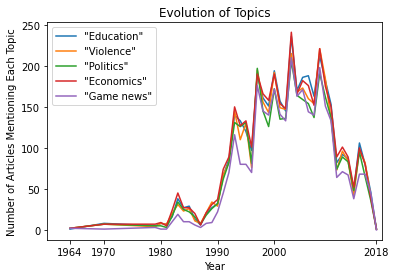

In [117]:
# Look at the number of articles mentioning each topic on one plot
for i in topics_of_interest:
    grouped = classified[['year', 'topic{}'.format(i)]].groupby('year').sum()
    grouped['total_per_yr'] = yearcounts[grouped.index]
    plt.plot(grouped.index, grouped['topic{}'.format(i)], label = topic_df.iloc[i].brief)
    plt.title("Evolution of Topics")
    setup_year_axis_plt()
    plt.ylabel("Number of Articles Mentioning Each Topic".format(i))
    plt.legend()
plt.show()

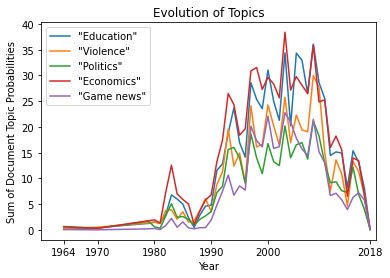

In [118]:
# Look at the number of articles mentioning each topic on one plot
# probability version (looks pretty similar)
for i in topics_of_interest:
    grouped = classified2[['year', 'topic{}'.format(i)]].groupby('year').sum()
    grouped['total_per_yr'] = yearcounts[grouped.index]
    plt.plot(grouped.index, grouped['topic{}'.format(i)], label = topic_df.iloc[i].brief)
    plt.title("Evolution of Topics")
    setup_year_axis_plt()
    plt.ylabel("Sum of Document Topic Probabilities".format(i))
    plt.legend()
plt.show()

One interesting thing about those two graphics:
- They both have the exact same shape;
- The second one has a bigger gap between the categories.

This first point can be explained by the discrepancies in the number of articles per year, which will be come evident after doing the same plot with relative numbers.

The second point seems to hint that there are topics where the model is way more confident in its assignment, since it consistently assigns higher probabilities throughout the years.

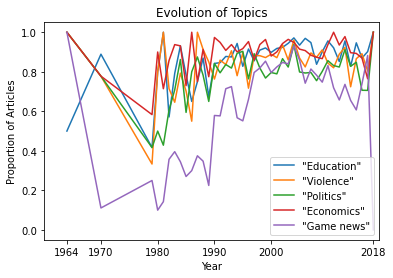

In [119]:
# Look at the proportion of articles mentioning each topic
for i in topics_of_interest:
    grouped = classified[['year', 'topic{}'.format(i)]].groupby('year').sum()
    grouped['total_per_yr'] = yearcounts[grouped.index]
    plt.plot(grouped.index, grouped['topic{}'.format(i)]/grouped.total_per_yr, label = topic_df.iloc[i].brief)
    plt.title("Evolution of Topics")
    setup_year_axis_plt()
    plt.ylabel("Proportion of Articles".format(i))
    plt.legend()
plt.show()

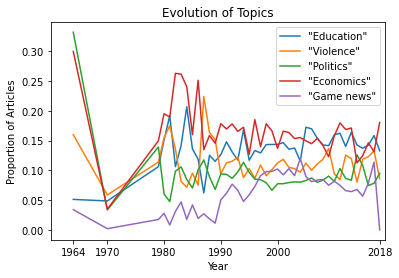

In [120]:
# Look at the proportion of articles mentioning each topic
# probability version
for i in topics_of_interest:
    grouped = classified2[['year', 'topic{}'.format(i)]].groupby('year').sum()
    grouped['total_per_yr'] = yearcounts[grouped.index]
    plt.plot(grouped.index, grouped['topic{}'.format(i)]/grouped.total_per_yr, label = topic_df.iloc[i].brief)
    plt.title("Evolution of Topics")
    setup_year_axis_plt()
    plt.ylabel("Proportion of Articles".format(i))
    plt.legend()
plt.show()

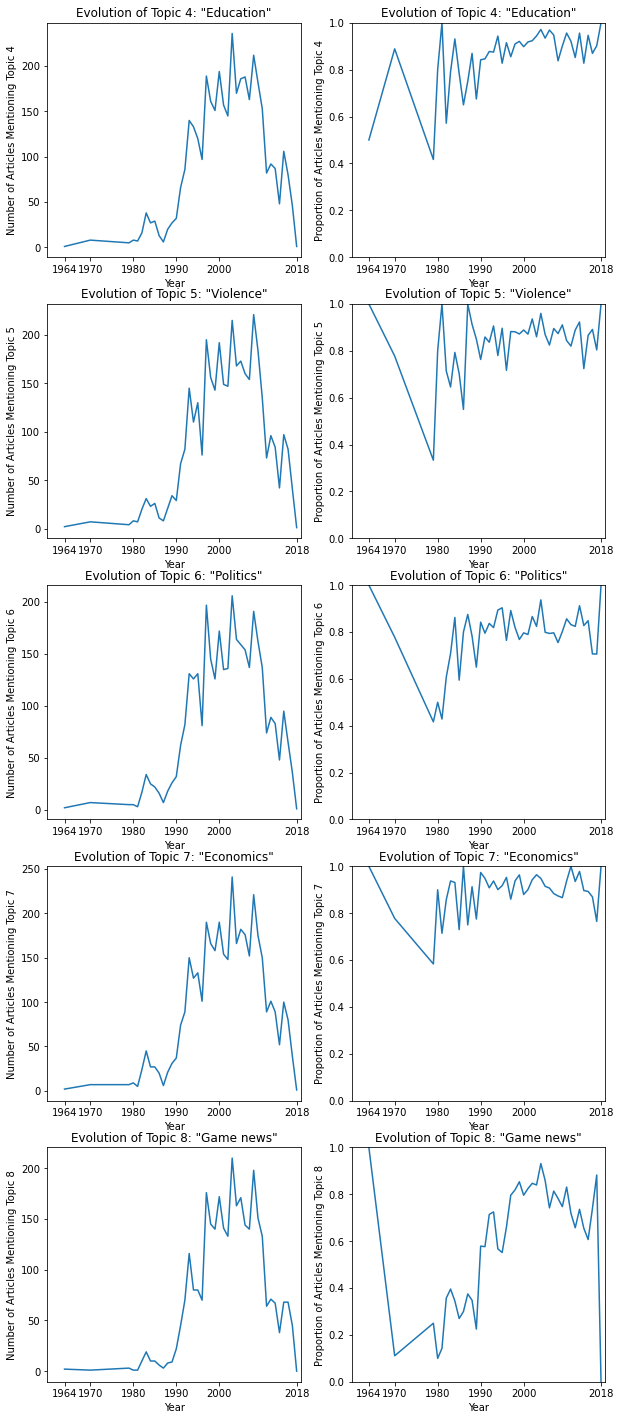

In [124]:
# Look at some of the more interesting topics
# Might be best to choose the most interesting topics and make a figure because it's a bit confusing all on one
# plot


fig = plt.figure(figsize = (10, 5 * len(topics_of_interest)))

for i, topic_id in enumerate(topics_of_interest):
    grouped = classified[['year', 'topic{}'.format(topic_id)]].groupby('year').sum()
    grouped['total_per_yr'] = yearcounts[grouped.index]

    ax_abs = fig.add_subplot(len(topics_of_interest), 2, 2*i + 1)
    ax_rel = fig.add_subplot(len(topics_of_interest), 2, 2*i + 2)


    ax_abs.plot(grouped.index, grouped['topic{}'.format(topic_id)])
    ax_abs.set_title("Evolution of Topic {}: {}".format(topic_id, topic_df.iloc[topic_id].brief))
    setup_year_axis(ax_abs)
    ax_abs.set_ylabel("Number of Articles Mentioning Topic {}".format(topic_id))

    ax_rel.plot(grouped.index, grouped['topic{}'.format(topic_id)]/grouped.total_per_yr)
    ax_rel.set_title("Evolution of Topic {}: {}".format(topic_id, topic_df.iloc[topic_id].brief))
    setup_year_axis(ax_rel)
    ax_rel.set_ylabel("Proportion of Articles Mentioning Topic {}".format(topic_id))
    ax_rel.set_ylim(0.0, 1.0)
plt.show()

The huge variations happening around 1964-1980 and around 2018 can be simply explained by the fact that there are really few articles in those periods, which implies that depending on a handful of assignments, the relative value can quickly jump to 1.0 or drop to 0.0.

In [28]:
min_text_len = 500 # Only keep longer articles, which are more interesting to analyze
keep_count = 5 # Number of articles to display

# Create a dictionary grouping the probabilities for each topic
topic_dict = {i: [] for i in range(9)} 

for docID in range(len(df.content)):
    topic_vector = lda_model[corpus[docID]]
    
    
    if len(df.content[docID]) > min_text_len:
        for topic, prob in topic_vector:
            topic_dict[topic].append((docID, prob))

# Sort the dictionary to find the top n document ids for each topic
for topic, probs in topic_dict.items():
    doc_probs = sorted(probs, key = lambda x: x[1], reverse = True)
    docs_top = [dp for dp in doc_probs[:keep_count]] 
    print(topic, brief[topic])
    print(docs_top)

0 consoles playstation nintendo
[(297, 0.39168602), (3889, 0.36431935), (820, 0.3564074), (177, 0.34271187), (451, 0.33584955)]
1 film combat action mission
[(2586, 0.49409467), (2585, 0.4940894), (2566, 0.48558393), (2565, 0.48558232), (199, 0.47322258)]
2 film story car
[(161, 0.78259623), (160, 0.7825951), (168, 0.5970634), (167, 0.5970617), (850, 0.53892654)]
3 children school young time
[(5, 0.88737065), (6, 0.8808923), (9, 0.8540933), (7, 0.8491672), (3, 0.8345734)]
4 art film screen children
[(16, 0.6404224), (3851, 0.6278196), (3850, 0.62385386), (1984, 0.6107961), (101, 0.55324817)]
5 violence
[(23, 0.57609284), (21, 0.5554249), (22, 0.55542135), (65, 0.5009943), (3328, 0.46463355)]
6 money funds
[(12, 0.74919695), (13, 0.74768645), (684, 0.5547808), (41, 0.55049324), (45, 0.52190125)]
7 money image american television
[(95, 0.71995234), (94, 0.7199514), (3880, 0.5832964), (141, 0.57769907), (52, 0.5625465)]
8 consoles playstation sony nintendo controller gun
[(1007, 0.5814094

With human intervention, it is possible to analyze those top documents to find a better label to the topic group:

0. No real link we could observe
1. Seems to link video-games with cinema (mostly articles)
2. Seems to link video-games with cinema (mostly annoucements about film related to videogames)
3. Always the same article (thanks impresso) about using videogames to teach watchmaking.
4. Education
5. Violence, but not in an expected way: "Battleships" and ISIS
6. Mostly "politic-related" stuff
7. Strong connection to economics; video games are usually just mentionned (funny to see they thought it was reaching its peak)
8. Mostly informations about the new games

In [125]:
# can look at the most representative documents for each topic
idx = 1007
print(df.iloc[idx])
df.content[idx]

uid                                                       IMP-1996-11-06-a-i0151
type                                                                         NaN
language                                                                      fr
title                                Jeux vidéo Après «Wipe Out» «Wipe Out 2097»
size                                                                         178
country                                                                       CH
newspaper                                                                    IMP
issue                                                           IMP-1996-11-06-a
pages                                                                         17
nb_pages                                                                       1
relevance                                                                    0.0
year                                                                        1996
is_on_front                 

"Jeux vidéo Après « Wipe Out » « Wipe Out 2097 » Si « Wipe Out », l'un des premiers jeux de la Playstation, n'était pas nouveau, ses graphismes, lors de sa sortie, avaient fait sensation et avaient ouverts les portes du succès à la console de Sony. Aujourd'hui, la nouvelle version de ce jeu d'enfer vient de sortir : « Wipe Out 2097 », ou comment on fait du neuf avec du vieux. Un jeu où l'on s'en donne à coeur joie dans des simulations de courses futuristes, un jeu dont l'innovation la plus marquante, en course, est l'apparition d'une harre d'énergie qui se vide dangereusement lors d'impacts ou de chocs. L'aspect graphique de l'ensemble a été complètement revu et amélioré. A en croire notre spécialiste de la console, Pascal Tissier, « Wipe Out » nouvelle formule procure déjà des sensations fortes après quelques minutes d'entraînement seulement. Et quand la piste se met à onduler, il faut vraiment s'accrocher ! _ _ p 25 « Wipe Out 2097 » comblera tous les amateurs de vitesse. Photo Psygn